### Goal: Create a mock image from a TNG50 SKIRT datacube
This notebook will walk through the steps to go from the SKIRT output cube into a reasonable mock of the user's choice of filter (from JWST or HST). 

The user can also set the redshift of the image and the size of the image cutout.

Things this notebook does:
1. Imports SED from SKIRT and describes the file (from Xuejian Shen).
2. Applies cosmological dimming and IGM absorption (from Xuejian Shen).
3. Uses SEDPY to create an image of a given filter.
4. Applies an appropriate PSF.
5. Rebins to the pixelscale of the instrument.
6. Introduces appropriate background residual.

Things I haven't done yet: 
1. Centering software to center on the galaxy of choice.
2. Determine (if we need) and implement background galaxies.
3. Potentially create an error image.

Things that need to be double checked:
1. The cosmological dimming.
2. Adding the background residuals in the appropriate units.

In [8]:
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from sedpy import observate
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import WMAP9 as cosmo
import astropy.constants as con
import os
import scipy
from scipy import ndimage
from astropy.convolution import convolve


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx], idx


### First load in the SED
This is a 3D datacube ('dusty_zoom1_total.fits'), it has not been mocked to observations,
meaning that we will need to apply cosmological dimming, extinction from the IGM, and apply the
appropriate filters. 

The SKIRT SED does include dust effects and is in units of MJy/Sr. The pixels are 90 pc pixels and the redshift of the galaxy is 2.

There is also a separate wavelength array.

In [9]:
im5 = pyfits.open('merger_images/dusty_zoom1_total.fits')

wav = np.loadtxt('merger_images/waves_low.dat')


### It is absolutely necessary to cut this image otherwise you will be working way too hard
For now, I'm just going to choose a location to 'center on' and cut around it

In [21]:
def cut_image(im5, cenx, ceny, cut_arc, size_pix_arc, kpc_arc, verbose):
    
    print('cutout size', cut_arc)
    print('size of a pix in arc', size_pix_arc)
    size_pix = int(cut_arc/size_pix_arc)
    print('n_pix', size_pix)
    img_cut = im5[0].data[:,ceny-size_pix:ceny+size_pix,cenx-size_pix:cenx+size_pix]

    size = np.shape(img_cut)[1]
    if verbose=='yes':
        plt.clf()
        imag = plt.imshow(np.sum(img_cut, axis=0), norm = matplotlib.colors.LogNorm(), cmap = 'magma')
        plt.scatter(size/2, size/2, color='red')
        plt.colorbar(imag, label = 'MJy/sr')
        locs = [0,size/2,size]
        labels = [round((size/2 - x)*size_pix_arc,1) for x in locs]
        labels_x = [round((size/2 - x)*size_pix_arc*kpc_arc,1) for x in locs]
        plt.xticks(locs,labels_x)
        plt.yticks(locs,labels)
        plt.xlabel('kpc')
        plt.ylabel('Arcsec')
        plt.show()
        
    
    return img_cut

Now, it is time to apply cosmological dimming 

In [22]:
def fnu_redshift(forigin,lamb,z):
        Dl=cosmo.luminosity_distance(z).value#*1e6
        #f_igm=forigin
        f_igm=cosmic_extinction(lamb,z)*forigin
        return f_igm*(1+z)*(1./Dl)**2,lamb*(1+z)

'''def fnu_redshift(forigin,lamb,z):
        Dl=cosmo.luminosity_distance(z).value
        
        #f_igm=forigin
        f_igm=cosmic_extinction(lamb,z)*forigin
        return f_igm*(1+z)**-5,lamb*(1+z)'''

def cosmic_extinction(lam,redshift):  # Madau (1995) prescription for IGM absorption
        lobs=lam*(1+redshift)
        t_eff=0.0*lam
        lyw = np.array([1215.67, 1025.72, 972.537, 949.743, 937.803,
        930.748, 926.226, 923.150, 920.963, 919.352,
        918.129, 917.181, 916.429, 915.824, 915.329,
        914.919, 914.576])
        lycoeff = np.array([0.0036,0.0017,0.0011846,0.0009410,0.0007960,
        0.0006967,0.0006236,0.0005665,0.0005200,0.0004817,
        0.0004487,0.0004200,0.0003947,0.000372,0.000352,
        0.0003334,0.00031644])

        l_limit = 911.75

        xem = 1. + redshift

        index=np.zeros(len(lyw),dtype=np.int32)
        for i in range(len(index)):
                index[i]=len(lam[lam< lyw[i]])

        for i in range(len(index)):
                t_eff[:index[i]] +=  lycoeff[i]*np.power(lobs[:index[i]]/lyw[i], 3.46)
                if i==0: t_eff[:index[i]] += 0.0017 * np.power(lobs[:index[i]]/lyw[i],1.68)

        index_lm=len(lam[lam< l_limit])
        xc = lobs[:index_lm]/l_limit
        t_eff[:index_lm] += 0.25*np.power(xc,3.)*(np.power(xem,0.46)-np.power(xc,0.46)) + 9.4*np.power(xc,1.5)*(np.power(xem,0.18)-np.power(xc,0.18)) - 0.7*np.power(xc,3.)*(np.power(xc,-1.32)-np.power(xem,-1.32)) - 0.023*(np.power(xem,1.68)-np.power(xc,1.68))

        tmax=np.max(t_eff)
        for i in range(len(lam)):
                if t_eff[i]==tmax:
                        maxloc=i
                        break
        t_eff[:maxloc]=tmax

        return np.exp(-t_eff)



def apply_filter(lamb, flux_MJy_sr, pixsize_pc,pixsize_arc,  redshift, bandlist):
    lamb=lamb*10000
    #lamb=np.append(10.,lamb)
    lamb=lamb[1:]
    
    flux=(flux_MJy_sr*1e6)/4.25e10 #unit Jy/arcsec (pixsize_pc/1e6)**2*
    #flux=np.append(0.,flux)
    
    #f_m_cgs=10**(-23)*flux*con.c.value/(lamb*1e-10)**2*(pixsize_pc/1e6)**2 #unit erg/s/cm^2/m
    #f_lambda_cgs = f_m_cgs/10**10 # convert to erg/s/cm^2/AA
    
    
    
    flux,lamb=fnu_redshift(flux,lamb,redshift)
    f_lambda_cgs=1e-7*flux*1e-26*con.c.value/(lamb*1e-10)**2 #unit erg/s/cm^2/AA

    #f_lambda_cgs_correct = 1e6*1e7*1e-4*flux*1e-26*con.c.value*1e-10/(lamb*1e-10)**2
    
    
    
    
    # What I think this should be to go from MJy/sr to erg/s/cm^2/AA/sr
    #f_lambda_cgs=1e6*flux*1e-23*con.c.value*1e10/(lamb)**2 #[]
    
    f_lambda_cgs_arc = (f_lambda_cgs)#/4.25e10)# also included this: *pixsize_arc**2
    
    f_AB = observate.getSED(lamb,f_lambda_cgs_arc,filterlist=bandlist)
    
    # Now get rid of the steradian, there are two methods
    #convert_pc = (pixsize_pc/1e6)**2 #[]
    #convert_arc = pixsize_arc**2/4.25e10 #[]
    
    #print('difference', convert_pc, convert_arc)
    
    
    return f_AB#, convert_arc



In [23]:
# Okay now run through each pixel?
# Probably there is a better way to do this than two for-loops

def produce_dimmed_Jy_filtered_image(bands, wav, img, pixelscale_pc,pixelscale_arc, redshift, l_eff, verbose):
    #bands=['wfc3_uvis_f814w','wfc3_ir_f105w','jwst_f150w']
           #'jwst_f070w','jwst_f090w','jwst_f115w','jwst_f150w','jwst_f200w','jwst_f277w','jwst_f356w','jwst_f444w']
    bandlist = observate.load_filters(bands)


    
    img_mag = np.zeros((np.shape(img)[1], np.shape(img)[2]))
    

    for i in range(np.shape(img)[1]):
        for j in range(np.shape(img)[2]):
            # the output of this is the value of the pixel in AB mags
            img_mag[i,j] = apply_filter(wav,img[:,i,j],pixelscale_pc,pixelscale_arc,  redshift,bandlist)
            

            
    size = np.shape(img)[1]

    if verbose=='yes':
        plt.clf()
        imag = plt.imshow(np.sum(img, axis=0), norm = matplotlib.colors.LogNorm(), cmap = 'magma')
        plt.scatter(size/2, size/2, color='red')
        plt.colorbar(imag, label = 'Bolometric MJy/sr')
        
        plt.show()

        plt.clf()
        plt.imshow(img_mag, cmap='magma_r')
        plt.colorbar(label='AB Mags')
        
        plt.show()
        

    
    # convert from AB mags to Janskies
    Janskies = 10**(img_mag/(-2.5))*3631# the AB mag zeropt is defined to be 3631 Jy
    
    
    
    # Now convert back to erg/s/cm2/A
    per_A = 2.99792458E-05 * Janskies / l_eff**2# l_eff is the effective wavelength
    # I'm not sure if this is right
    
    if verbose=='yes':
        

        plt.clf()
        plt.imshow(Janskies, cmap='magma_r')
        plt.colorbar(label='Jy')
        plt.xlabel('Arcsec')
        plt.show()
        
        
        plt.clf()
        plt.imshow(per_A, cmap='magma_r')
        plt.colorbar(label='erg/s/cm2/A')
        plt.xlabel('Arcsec')
        plt.show()
        
        

    return per_A

### Now, time to apply the PSF and rebin

This is a little tricky because I think you first need the PSF to be the same size pixels (in arcsec)
as the image. This means you are fudging the size a little so Im not sure if there is a better way to do this. 
When I was doing this with SDSS I was able to use astropy.convolves 2D Gaussian function to create my own PSF
because SDSSs PSF was reasonably Gaussian in shape so I never ran into this concern.

In [24]:
# We still need to decide which order to do these in
# I think because we have the psf in image form, we should keep it as is and first rebin
# the mock image to the appropraite HST pixelscale
def convolve_and_rebin(Janskies, psf, size_pix_arc, size_detector_pix_arc, verbose):
    
    
    
    if verbose=='yes':
        plt.clf()
        plt.imshow(psf[0].data, norm=matplotlib.colors.LogNorm())
        plt.colorbar()
        plt.show()



    
    
    factor = size_pix_arc/size_detector_pix_arc

    print('factor of rebin', factor, 'this is size of pix in arc in OG', size_pix_arc)
    print('this is size of pix in arc in rebinned', size_detector_pix_arc)
    
    
    rebin = scipy.ndimage.zoom(Janskies, factor, order=0)

    

    if verbose=='yes':
        plt.clf()
        plt.imshow(rebin, cmap='magma_r')#, vmin=min_mag, vmax=max_mag)
        plt.colorbar()
        plt.title('Rebinned')
        size = np.shape(rebin)[1]
        locs = [0,size/2,size]
        labels = [round((size/2 - x)*size_detector_pix_arc,1) for x in locs]
        plt.xticks(locs,labels)
        plt.yticks(locs,labels)
        plt.show()
        
    print('now this is the size of this GD image', np.shape(rebin))   
    STOP
    try:
        result = (convolve(rebin, psf[0].data))#was rebin_psf
    except:
        # this is an error that occurs when the psf doesn't have odd dimensions
        
        
        result = convolve(rebin, psf[0].data[1:,1:])
        
        
    
    if verbose=='yes':
        plt.clf()
        plt.imshow(result, cmap='magma_r')
        plt.colorbar()
        plt.title('Convolved')
        plt.show()

    
    return  result, rebin


### Add Noise :)
I found in this article (https://iopscience.iop.org/article/10.1088/0067-0049/197/2/36) that:

We have verified that the degree of flatness of the final sky backgrounds in the images is within ~1%–2% of the mean sky level.

Also in this source they discuss the 5sigma limiting magnitude for both point sources and extended sources. 
For ACS/WFC F814W this number is 26.67 and is 26.80 for F125W.

I think we can use the formula to convert between counts and magnitudes to determine the counts of this limiting surface brightness.

In [25]:
def background_resids(bg_limiting_sb_flambda,size_detector_pix_arc, l_eff, rebin, verbose):
    '''Jy_limit = 10**(26.67/(-2.5))*3631
    print('jy limit', Jy_limit)
    Jy_resids = 0.02*Jy_limit
    print('variation Jy', Jy_resids)'''


    
    
    bg_limiting_flambda = bg_limiting_sb_flambda#*size_detector_pix_arc**2

    # Try converting this into a per Hz unit by multiply by lambda_eff**2/c
    #bg_limiting_fnu = bg_limiting_flambda*(l_eff**2/2.998e18)*10**(23)
    bg_resids_flambda = 0.02*bg_limiting_flambda
    
    print('sigma bg', bg_resids_flambda)
    
    #print('converted to Jy ', bg_resids_fnu)


    #according to the above article, the fluctuations in the bg are 1-2%


    background = np.zeros(np.shape(rebin))
    mu, sigma = 0, bg_resids_flambda # mean and standard deviation

    for i in range(np.shape(background)[0]):
        for j in range(np.shape(background)[1]):
            s = np.random.normal(mu, sigma, 1)
            background[i,j] = s

    if verbose=='yes':
        plt.clf()
        plt.imshow(background, cmap='magma_r')
        plt.colorbar(label='erg/s/cm2/AA/arcsec^2')
        plt.show()

        plt.clf()
        plt.imshow(rebin+background, cmap='magma_r')
        plt.colorbar(label='erg/s/cm2/AA/arcsec^2')
        plt.show()
    return background




### Put it all together
This code runs all of the above codes:
    

In [28]:
def combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name,bg_limiting_sb_flambda,size_detector_pix_arc, l_eff, verbose):
    if verbose=='yes':
        plt.clf()
        imag = plt.imshow(np.sum(im5[0].data, axis=0), norm = matplotlib.colors.LogNorm(), cmap = 'magma')
        plt.colorbar(imag, label = 'MJy/sr')
        locs, labels = plt.xticks()
        print(labels[1], locs)
        #plt.xticklabels()
        plt.show()
    
    pixelscale_pc = im5[0].header['CDELT1']
    pixelscale_kpc = pixelscale_pc/1000
    
    print('pixel in pc', pixelscale_pc, 'iin kpc', pixelscale_kpc)
    
    #The number of pixels on each side is 500. The field of view is 45kpc on each side.
    
    
    # So this part is confusing me
    # The camera for capturing the SKIRT cube is apparently placed at 1Mpc away from the galaxy
    # So should we put 'redshift' as the redshift that corresponds to 1Mpc or
    # should redshift be z=2?
    # The pixelscale is 90 pc/pixel or 0.09 kpc/pixel and it needs a redshift to convert
    # to a pixelscale in arcsec
    # I think we should use the second option
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift to get the kpc/arcmin scaling                      
    
    size_pix_arc = pixelscale_kpc / (kpc_arcmin.value/60)
    
    #Also original arcsec size is much much smaller
    
    
   
    
    # This would be the code if we were to place the galaxy at 1Mpc instead:
    from astropy.cosmology import Planck13, z_at_value
    import astropy.units as u
    new_redshift = z_at_value(Planck13.angular_diameter_distance,1 * u.Mpc, zmax=1.5)  
    
    kpc_arcmin_OG=cosmo.kpc_proper_per_arcmin(new_redshift)#insert the redshift to get the kpc/arcmin scaling                      
    
    size_pix_arc_OG = pixelscale_kpc / (kpc_arcmin_OG.value/60)
    
    
    
    # First, cut the image to some size in arcsec which you specify
    img_cut = cut_image(im5, cenx, ceny, cut_arc, size_pix_arc, kpc_arcmin.value/60, verbose)
    
    STOP
    
    

    # This code then filters and cosmologically dims the image
    Jy = produce_dimmed_Jy_filtered_image(filter_name, wav, img_cut, pixelscale_pc,  size_pix_arc_OG, redshift, l_eff, verbose)


    # We are assuming the PSF has the same pixelscale as the HST image for that filter
    psf = pyfits.open('../Kinematics_SUNRISE/HST_broadband/'+str(filter_id)+'_forBecky00.fits')
    
    # This code will rebin and then convolve the image in Janskies using the above psf
    conv, rebin = convolve_and_rebin(Jy, psf, size_pix_arc_OG, size_detector_pix_arc, verbose)

    # the last step is to add background
    bg = background_resids(bg_limiting_sb_flambda, size_detector_pix_arc, l_eff, conv, verbose)



    return conv+bg

Text(0, 0, '') [-100.    0.  100.  200.  300.  400.  500.]


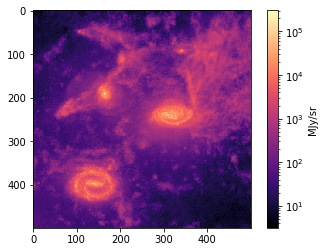

pixel in pc 90.0 iin kpc 0.09
cutout size 400
size of a pix in arc 0.010524250748966657
n_pix 38007


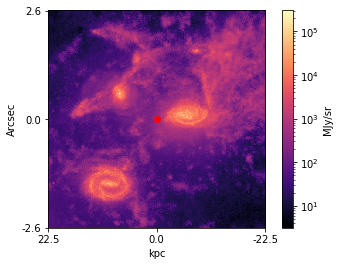

NameError: name 'STOP' is not defined

In [29]:
verbose='yes'
redshift = 2

'''cenx = 315
ceny = 240
cut_arc = 12.6'''
cenx = 166
ceny = 188
cut_arc = 12.6

# This is between two galaxies:
cenx = 240
ceny = 218

cenx = 270
ceny = 358

cenx = 166
ceny = 188
cut_arc = 400#was 1.5 3.5


'''cenx = 166
ceny = 188
cut_arc=1.5'''
# These are the detector/filter params:

# WFC3: 
# The UVIS detector has a plate scale ~0.04 arcsec/pixel, 
# and the point spread function (PSF) has FWHM 1.6 to 2.3 pixels, depending on wavelength. 
# The IR detector provides coarser sampling of the PSF, with a plate scale of 0.13 arcsec/pixel 
# and FWHM of 1.0 to 1.2 pixels, 
# so IR imaging will benefit even more than UVIS imaging from combining dithered exposures.

# ACS/WFC:
# pixel scale is 0.05 arcsec/pixel

#F435W ACS/WFC
size_detector_pix_arc = 0.05
bg_limiting_sb_flambda = 7.57e-18
l_eff = 4350
filter_id = 'f435w'
filter_name = ['acs_wfc_f435w']

mock_f435w = combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name, bg_limiting_sb_flambda,
              size_detector_pix_arc, l_eff, verbose)




#F814W ACS/WFC
size_detector_pix_arc = 0.05
bg_limiting_sb_flambda = 5.38e-18
l_eff = 8140
filter_id = 'f814w'
filter_name = ['acs_wfc_f814w']

mock_f814w = combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name, bg_limiting_sb_flambda,
              size_detector_pix_arc, l_eff, verbose)


#F160W WFC3/IR
filter_id = 'f160w'
size_detector_pix_arc = 0.13
bg_limiting_sb_flambda = 1.43e-18
l_eff = 16000
filter_name = ['wfc3_ir_f160w']




mock_f160w = combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name, bg_limiting_sb_flambda,
              size_detector_pix_arc, l_eff, verbose)



kpc/arcsec 8.5516776582729
pixelscale kpc 0.09
cutout size 2000.5
size of a pix in arc 0.010524250748966657
n_pix 190084


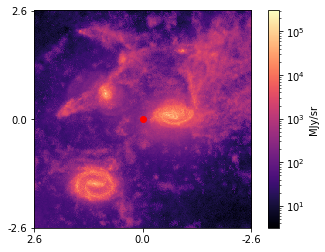

<Figure size 432x288 with 0 Axes>

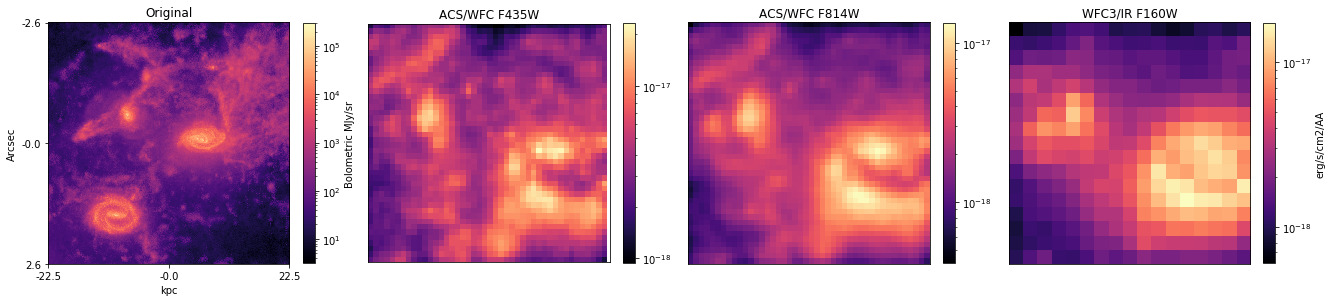

In [177]:
pixelscale_pc = im5[0].header['CDELT1']
pixelscale_kpc = im5[0].header['CDELT1']/1000

kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift to get the kpc/arcmin scaling                      

print('kpc/arcsec', (kpc_arcmin.value/60))
print('pixelscale kpc', pixelscale_kpc)

size_pix_arc = pixelscale_kpc / (kpc_arcmin.value/60)


size = np.shape(np.sum(im5[0].data, axis=0))[1]




img_cut = cut_image(im5, cenx, ceny, cut_arc, size_pix_arc, verbose)

plt.clf()
fig = plt.figure(figsize=(22,10))

ax0 = fig.add_subplot(141)
im0 = ax0.imshow(np.sum(img_cut, axis=0), cmap='magma', norm=matplotlib.colors.LogNorm())
ax0.set_title('Original')
plt.colorbar(im0, fraction=0.045, label='Bolometric MJy/sr')
size = np.shape(img_cut)[1]
locs = [0,size/2,size]
labels = [-round((size/2 - x)*size_pix_arc,1) for x in locs]
labels_x = [-round((size/2 - x)*size_pix_arc*(kpc_arcmin.value/60),1) for x in locs]
ax0.set_xticks(locs)
ax0.set_xticklabels(labels_x)
ax0.set_xlabel('kpc')
ax0.set_yticks(locs)
ax0.set_yticklabels(labels)
ax0.set_ylabel('Arcsec')

ax1 = fig.add_subplot(142)
im1 = ax1.imshow(abs(mock_f435w), cmap='magma', norm=matplotlib.colors.LogNorm())
ax1.set_title('ACS/WFC F435W')
size = np.shape(mock_f435w)[1]
locs = [0,size/2,size]
size_detector_pix_arc = 0.05
labels = [-round((size/2 - x)*size_detector_pix_arc,1) for x in locs]
ax1.set_xticks(locs)
ax1.set_xticklabels(labels)
ax1.set_xticks([])
ax1.set_yticks([])
plt.colorbar(im1, fraction=0.045)


ax2 = fig.add_subplot(143)
im2 = ax2.imshow(abs(mock_f814w), cmap='magma', norm=matplotlib.colors.LogNorm())
ax2.set_title('ACS/WFC F814W')
size = np.shape(mock_f814w)[1]
locs = [0,size/2,size]
labels = [-round((size/2 - x)*size_detector_pix_arc,1) for x in locs]
ax2.set_yticks([])
ax2.set_xticks([])
plt.colorbar(im2, fraction=0.045)
#plt.show()

ax3 = fig.add_subplot(144)
im3 = ax3.imshow(abs(mock_f160w), cmap='magma', norm=matplotlib.colors.LogNorm())
ax3.set_title('WFC3/IR F160W')
size = np.shape(mock_f160w)[1]
locs = [0,size/2,size]
size_detector_pix_arc = 0.13
labels = [-round((size/2 - x)*size_detector_pix_arc,1) for x in locs]
ax3.set_xticks([])
ax3.set_yticks([])
plt.colorbar(im3, label='erg/s/cm2/AA', fraction=0.045)
plt.savefig('mock_panels/Galaxy_mock_images_HST_Xuejian.png', dpi=500)



### Now its time to compare to an actual HST image
This is a good way to make sure the background we derived above makes sense

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1001 / Axis length                                    
NAXIS2  =                 1001 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2014-06-13T20:06:24' / Date FITS file was generated                  
IRAF-TLM= '2014-06-13T20:06:24' / Time of last modification                     
NEXTEND =                    3 / Number of standard extensions                  
FILENAME= 'ibwe01030_drz.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                            

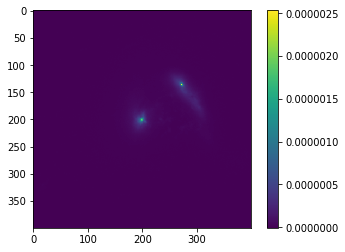

mean 9.897727e-09
std in Jy 4.4995677e-08
multiply by this 3.2471999e-07
Fnu [[ 5.7530819e-10  7.0973710e-10  1.7671029e-09 ...  2.7403421e-10
  -1.2245212e-10 -1.7509315e-09]
 [ 7.3074086e-10 -3.0199046e-10  1.9016493e-09 ...  5.9311228e-10
   2.6508807e-11 -6.7483930e-10]
 [-1.8842656e-09 -4.0301456e-09  3.2630527e-09 ...  1.2214355e-10
   2.6562628e-09  1.8982662e-09]
 ...
 [ 7.1243200e-10 -7.3209172e-10 -3.7726000e-10 ...  8.5421947e-12
  -1.0434726e-09 -1.2983921e-09]
 [-3.5733158e-10  1.4332386e-09  1.8583772e-09 ...  5.4099059e-10
  -1.7067588e-09 -7.4072815e-10]
 [ 1.4367476e-11  1.6894861e-09  1.9237385e-09 ...  7.0013567e-10
  -1.5841034e-09 -1.7586229e-09]]


<Figure size 432x288 with 0 Axes>

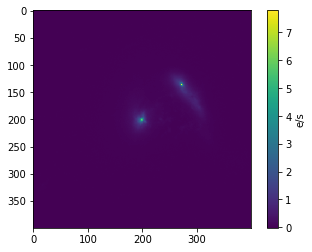

<Figure size 432x288 with 0 Axes>

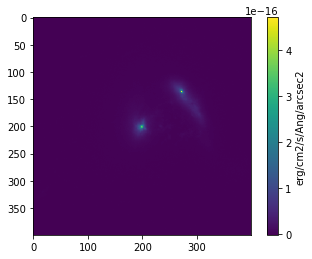

<Figure size 432x288 with 0 Axes>

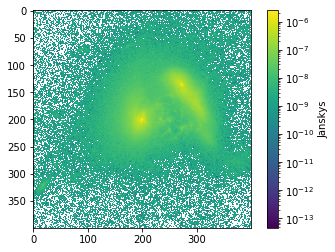

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in log10


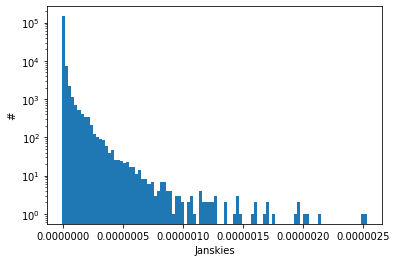

9.897727e-09 4.4995677e-08


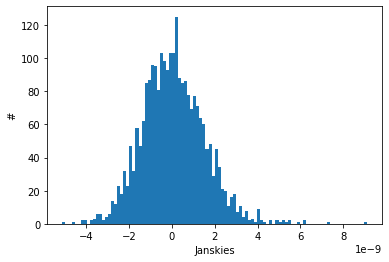

7.277546e-11 1.4466852e-09


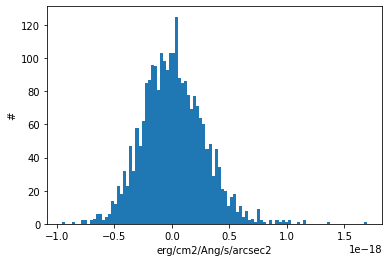

1.3554215e-20 2.6944088e-19


In [145]:
#The units of this image are electrons
img = pyfits.open('../Kinematics_SUNRISE/HST_broadband/F814W_drz_sci_rot_crop.fits')
print(img)

image = img[0].data[300:700,300:700]

print(repr(img[0].header))




plt.imshow(image*img[0].header['PHOTFNU'])
plt.colorbar()
plt.show()

print('mean', np.mean(image*img[0].header['PHOTFNU']))
print('std in Jy', np.std(image*img[0].header['PHOTFNU']))


print('multiply by this', img[0].header['PHOTFNU'])

# Put the image in Fnu units (Jy)
Fnu = (image*img[0].header['PHOTFNU'])#/img[0].header['EXPTIME']
Flam = (image*img[0].header['PHOTFLAM'])/0.05**2
print('Fnu', Fnu)


plt.clf()
fig=plt.figure()
ax0 = fig.add_subplot(111)#img[0].header['EXPTIME']
im0 = ax0.imshow(image)
#
plt.colorbar(im0, label='e/s')
#ax0.scatter(img[0].header['CRPIX1'], img[0].header['CRPIX2'])
#40 arcseconds across
#

'''arcsec = 25/2
ax0.set_xticks([img[0].header['OCRPIX1']-(arcsec/(img[0].header['CD1_1']*3600)),img[0].header['OCRPIX1'],img[0].header['OCRPIX1']+(arcsec/(img[0].header['CD1_1']*3600)) ])
ax0.set_xticklabels([arcsec,0,-arcsec])

ax0.set_yticks([img[0].header['OCRPIX2']-(arcsec/(img[0].header['CD2_2']*3600)),img[0].header['OCRPIX2'],img[0].header['OCRPIX2']+(arcsec/(img[0].header['CD2_2']*3600)) ])
ax0.set_yticklabels([-arcsec,0,arcsec])

ax0.set_xlim([img[0].header['OCRPIX1']+(arcsec/(img[0].header['CD1_1']*3600)),img[0].header['OCRPIX1']-(arcsec/(img[0].header['CD1_1']*3600))])
ax0.set_ylim([img[0].header['OCRPIX2']+(arcsec/(img[0].header['CD2_2']*3600)), img[0].header['OCRPIX2']-(arcsec/(img[0].header['CD2_2']*3600))])
'''
plt.show()


plt.clf()
fig=plt.figure()
ax0 = fig.add_subplot(111)#img[0].header['EXPTIME']
im0 = ax0.imshow(Flam)
#
plt.colorbar(im0, label='erg/cm2/s/Ang/arcsec2')
#ax0.scatter(img[0].header['CRPIX1'], img[0].header['CRPIX2'])
#40 arcseconds across
#

'''arcsec = 25/2
ax0.set_xticks([img[0].header['OCRPIX1']-(arcsec/(img[0].header['CD1_1']*3600)),img[0].header['OCRPIX1'],img[0].header['OCRPIX1']+(arcsec/(img[0].header['CD1_1']*3600)) ])
ax0.set_xticklabels([arcsec,0,-arcsec])

ax0.set_yticks([img[0].header['OCRPIX2']-(arcsec/(img[0].header['CD2_2']*3600)),img[0].header['OCRPIX2'],img[0].header['OCRPIX2']+(arcsec/(img[0].header['CD2_2']*3600)) ])
ax0.set_yticklabels([-arcsec,0,arcsec])

ax0.set_xlim([img[0].header['OCRPIX1']+(arcsec/(img[0].header['CD1_1']*3600)),img[0].header['OCRPIX1']-(arcsec/(img[0].header['CD1_1']*3600))])
ax0.set_ylim([img[0].header['OCRPIX2']+(arcsec/(img[0].header['CD2_2']*3600)), img[0].header['OCRPIX2']-(arcsec/(img[0].header['CD2_2']*3600))])
'''
plt.show()


plt.clf()
fig=plt.figure()
ax0 = fig.add_subplot(111)#img[0].header['EXPTIME']
im0 = ax0.imshow(Fnu, norm=matplotlib.colors.LogNorm())
#
plt.colorbar(im0, label='Janskys')
#ax0.scatter(img[0].header['CRPIX1'], img[0].header['CRPIX2'])
#40 arcseconds across
#


plt.show()




# Optionally then convert from Fnu units into AB mag units by finding the zeropoint
ABMAG_ZPT = -2.5*np.log10(img[0].header['PHOTFLAM']) - 21.10 - 5*np.log10(img[0].header['PHOTPLAM']) + 18.692
ABMAG = -2.5*np.log10(Fnu) - ABMAG_ZPT#48.6





# Aimee has a better way of doing this that looks only at the background-dominated regions


hist_data = np.ma.masked_where(Fnu==0., Fnu).flatten()

plt.clf()
hist1 = plt.hist(hist_data, bins=100)
#plt.xlim([-1,1])
plt.yscale('log', nonposy='clip')
plt.ylabel('#')
plt.xlabel('Janskies')
#plt.xlim([-100,100])
plt.show()

#print(hist1)

# These should be the image statistics in Jy
print(np.mean(hist_data),np.std(hist_data))


# what about if you only take the BG?
hist_data = Fnu[0:50,0:50].flatten()

plt.clf()
hist1 = plt.hist(hist_data, bins=100)
#plt.xlim([-1,1])
#plt.yscale('log', nonposy='clip')
plt.ylabel('#')
plt.xlabel('Janskies')
#plt.xlim([-100,100])
plt.show()

#print(hist1)

# These should be the image statistics in Jy
print(np.mean(hist_data),np.std(hist_data))


hist_data = Flam[0:50,0:50].flatten()

plt.clf()
hist1 = plt.hist(hist_data, bins=100)
#plt.xlim([-1,1])
#plt.yscale('log', nonposy='clip')
plt.ylabel('#')
plt.xlabel('erg/cm2/Ang/s/arcsec2')
#plt.xlim([-100,100])
plt.show()

#print(hist1)

# These should be the image statistics in Jy
print(np.mean(hist_data),np.std(hist_data))


In [146]:
### Show them side by side

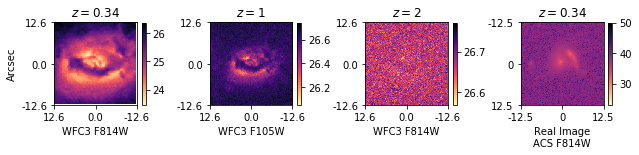

In [178]:
#final_mag_z_2 = final_mags
#final_mag_z_half = final_mags
#final_mag_z_same = final_mags
final_mag_z_1 = final_mags
fig = plt.figure(figsize = (10,7))

ax0 = fig.add_subplot(141)
im0 = ax0.imshow(final_mag_z_same, cmap='magma_r')#, vmin=20,vmax=26)#, vmin=24, vmax=28)
plt.colorbar(im0, fraction=0.045)
ax0.set_title('$z = 0.34$')
ax0.set_xlabel('WFC3 F814W')

locs = [0,size/2,size]
labels = [round((size/2 - x)*0.04,1) for x in locs]
ax0.set_xticks(locs)
ax0.set_xticklabels(labels)
ax0.set_yticks(locs)
ax0.set_yticklabels(labels)
ax0.set_ylabel('Arcsec')

ax1 = fig.add_subplot(142)
im1 = ax1.imshow(final_mag_z_1, cmap='magma_r')#, vmin=24, vmax=28)
plt.colorbar(im1, fraction=0.045)
ax1.set_title('$z = 1$')
ax1.set_xlabel('WFC3 F105W')

ax1.set_xticks(locs)
ax1.set_xticklabels(labels)
ax1.set_yticks(locs)
ax1.set_yticklabels(labels)


ax3 = fig.add_subplot(143)
im3 = ax3.imshow(final_mag_z_2, cmap='magma_r')#, vmin=24, vmax=28)
plt.colorbar(im3, fraction=0.045)
ax3.set_title('$z = 2$')
ax3.set_xlabel('WFC3 F814W')
ax3.set_xticks(locs)
ax3.set_xticklabels(labels)
ax3.set_yticks(locs)
ax3.set_yticklabels(labels)

ax4 = fig.add_subplot(144)
im4 = ax4.imshow(m, cmap='magma_r', vmin=23, vmax=50)#, vmin=20,vmax=26)#, vmin=0, vmax=27)
arcsec = 25/2
ax4.set_xticks([img[0].header['OCRPIX1']-(arcsec/(img[0].header['CD1_1']*3600)),img[0].header['OCRPIX1'],img[0].header['OCRPIX1']+(arcsec/(img[0].header['CD1_1']*3600)) ])
ax4.set_xticklabels([arcsec,0,-arcsec])

ax4.set_yticks([img[0].header['OCRPIX2']-(arcsec/(img[0].header['CD2_2']*3600)),img[0].header['OCRPIX2'],img[0].header['OCRPIX2']+(arcsec/(img[0].header['CD2_2']*3600)) ])
ax4.set_yticklabels([-arcsec,0,arcsec])

ax4.set_xlim([img[0].header['OCRPIX1']+(arcsec/(img[0].header['CD1_1']*3600)),img[0].header['OCRPIX1']-(arcsec/(img[0].header['CD1_1']*3600))])
ax4.set_ylim([img[0].header['OCRPIX2']+(arcsec/(img[0].header['CD2_2']*3600)), img[0].header['OCRPIX2']-(arcsec/(img[0].header['CD2_2']*3600))])
plt.colorbar(im4, fraction=0.045)
ax4.set_title('$z = 0.34$')
ax4.set_xlabel('Real Image\nACS F814W')

plt.subplots_adjust(hspace=0.5, wspace=0.7)

plt.savefig('ADAP.png', dpi=500)

(234, 500, 500) (235,)


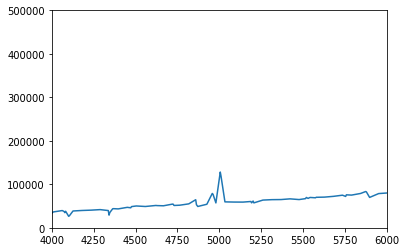

In [22]:
print(np.shape(im5[0].data), np.shape(wav))
SKIRT_spec = np.sum(im5[0].data, axis=(1,2))
plt.clf()
plt.plot(wav[1:]*10**4, SKIRT_spec*wav[1:])
#plt.xlim([0.4,0.6])
plt.xlim([4000,6000])
plt.ylim([0,5e5])
plt.show()

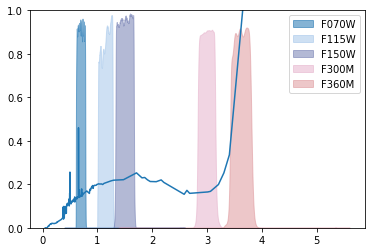

In [7]:


# Try to get individual filter curves
F070W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F070W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F115W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F115W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F140M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F140M_filteronly_ModAB_mean.txt',
                  skiprows=1)
F150W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F150W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F150W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F150W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F300M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F300M_filteronly_ModAB_mean.txt',
                  skiprows=1)
F360M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F360M_filteronly_ModAB_mean.txt',
                  skiprows=1)
F480M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F480M_filteronly_ModAB_mean.txt',
                  skiprows=1)


#format is microns and throughput
plt.fill_between(F070W[:,0], 0, F070W[:,1], label='F070W', color='#0D69AB', alpha=0.5)

plt.fill_between(F115W[:,0], 0, F115W[:,1], label='F115W', color='#9FC3E9', alpha=0.5)
plt.fill_between(F150W[:,0], 0, F150W[:,1], label='F150W', color='#6874AC', alpha=0.5)
plt.fill_between(F300M[:,0], 0, F300M[:,1], label='F300M',color='#E4ADC8', alpha=0.5)
plt.fill_between(F360M[:,0], 0, F360M[:,1], label='F360M',color='#DC9095', alpha=0.5)

plt.plot(wav[1:], SKIRT_spec/1e6)
#plt.xlim([0,2])
plt.ylim([0,1])
#plt.xlim([0.6,0.67])
plt.legend()
plt.show()

# Okay how do I select?
#np.convolve(SKIRT_spec)
from scipy import interpolate, fftpack



(234, 500, 500)


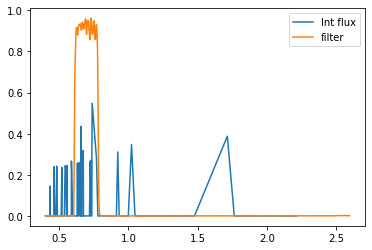

0.40078326999999997 0.39914999389648437
(160,) (160,) (160,) (2201,) (2201,)


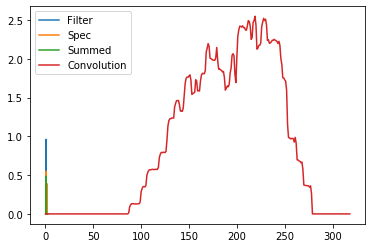

NameError: name 'STOP' is not defined

In [20]:
# Now how to translate this into an image?
# Oh ****, gotta do a multiplication in 3D 


# Check out Xuejian's code - https://bitbucket.org/ShenXuejian/dust-modeling/src/master/modelC/TUNE/tune_getapmag.py
# Also: https://github.com/gbrammer/sedpy/blob/master/sedpy/observate.py
# Also the SVO filter curves: http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=JWST

def get_broadband(wav, cube, filter_jwst):
    # Input the cube and wavelength, cut into the area for each filter, 
    # and output the broadband image summed over those wavelengths
    print(np.shape(cube))
    broadband_img = np.zeros((np.shape(cube)[1], np.shape(cube)[2]))
    
    for i in range(np.shape(cube)[1]):
        for j in range(np.shape(cube)[2]):
            spec = cube[:,i,j]
            #SKIRT_spec = np.sum(im5[0].data, axis=(1,2))

            cut_index0 = find_nearest(wav,filter_jwst[:,0][0])[1]
            cut_index1 = find_nearest(wav,filter_jwst[:,0][-1])[1]
            int_func = interpolate.interp1d(filter_jwst[:,0],filter_jwst[:,1])#wav[1:], SKIRT_spec)
            plt.clf()
            plt.plot(wav[cut_index0:cut_index1], 
                                            spec[cut_index0:cut_index1], label='Int flux')
            plt.plot(filter_jwst[:,0],filter_jwst[:,1], label='filter')
            #plt.plot(wav[cut_index0:cut_index1],spec[cut_index0:cut_index1],label='OG spec')
            #plt.plot(wav[cut_index0:cut_index1],int_flux, label='Filter')
            plt.legend()
            plt.show()
            try:
                print(wav[cut_index0], filter_jwst[:,0][0])
                int_flux = int_func(wav[cut_index0:cut_index1])
                broadband_img[i,j] = np.sum(int_flux*spec[cut_index0:cut_index1])
                conv = np.convolve(int_flux,spec[cut_index0:cut_index1])
                print(np.shape(wav[cut_index0:cut_index1]), np.shape(spec[cut_index0:cut_index1]),
                     np.shape(int_flux), np.shape(filter_jwst[:,1]), np.shape(filter_jwst[:,0]))
                plt.clf()
                plt.plot(wav[cut_index0:cut_index1],int_flux, label='Filter')
                plt.plot(wav[cut_index0:cut_index1],spec[cut_index0:cut_index1], label='Spec')
                plt.plot(wav[cut_index0:cut_index1], int_flux*spec[cut_index0:cut_index1], label='Summed')
                plt.plot( conv, label='Convolution')
                #plt.plot(wav[cut_index0:cut_index1],spec[cut_index0:cut_index1],label='OG spec')
                #plt.plot(wav[cut_index0:cut_index1],int_flux, label='Filter')
                plt.legend()
                plt.show()
                
                
                STOP
            except:
                STOP
                
                
                nonzero = np.where(filter_jwst[:,1] > 0.01)
                nonzero_filter = filter_jwst[:,1][nonzero]
                nonzero_filter_x = filter_jwst[:,0][nonzero]
                
                
                
                if nonzero_filter_x[-1] > wav[-1]:
                    print('Filter not covered')
                    print('final wavelength of the filter', nonzero_filter_x[-1], 'final wav', wav[-1])
                    
                    plt.clf()
                    plt.plot(nonzero_filter_x, nonzero_filter)
                    plt.show()
                    
                    STOP
                    return broadband_img
                
                else:
                    int_flux = int_func(nonzero_filter_x)
                    broadband_img[i,j] = np.sum(nonzero_filter*int_flux)
                    plt.plot(no)
                    #mayebs show the difference betwen convolution and just summing the multiplication first?
                    
                    STOP
            
            '''plt.clf()
            plt.plot(filter_jwst[:,0], filter_jwst[:,1]*int_flux, label='Interpolated Fluxes')
            plt.fill_between(filter_jwst[:,0], 0, filter_jwst[:,1], label='F150W', color='#6874AC', alpha=0.5)

            plt.legend()
            #plt.xlim([1.2,1.6])
            plt.show()'''
    return broadband_img
F070W_img = get_broadband(wav[1:], im5[0].data, F070W)
F115W_img = get_broadband(wav[1:], im5[0].data, F115W)
F150W_img = get_broadband(wav[1:], im5[0].data, F150W)
F300M_img = get_broadband(wav[1:], im5[0].data, F300M)
F360M_img = get_broadband(wav[1:], im5[0].data, F360M)



(500, 500)
Text(0, 0, '') [-100.    0.  100.  200.  300.  400.  500.]


<Figure size 432x288 with 0 Axes>

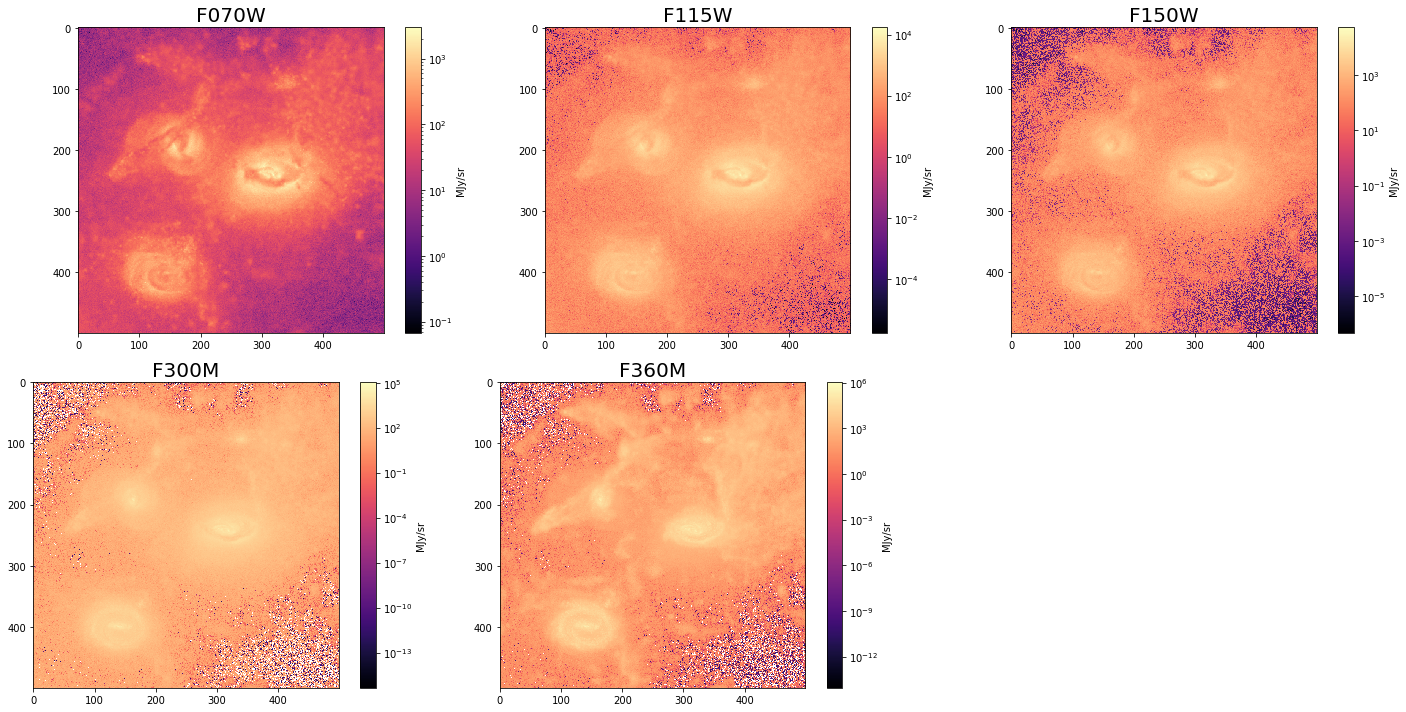

In [17]:
## Now you can make a beautiful image for all the different broadband filters :)
print(np.shape(F115W_img))

universal_cmap = 'magma'

plt.clf()
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(231)
im0 = ax0.imshow(F070W_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im0, label = 'MJy/sr', fraction = 0.046)
ax0.set_title('F070W', size=20)

ax1 = fig.add_subplot(232)
im1 = ax1.imshow(F115W_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im1, label = 'MJy/sr', fraction = 0.046)
ax1.set_title('F115W', size=20)

ax2 = fig.add_subplot(233)
im2 = ax2.imshow(F150W_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im2, label = 'MJy/sr', fraction = 0.046)
ax2.set_title('F150W', size=20)

ax3 = fig.add_subplot(234)
im3 = ax3.imshow(F300M_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im3, label = 'MJy/sr')
ax3.set_title('F300M', size=20)

ax4 = fig.add_subplot(235)
im4 = ax4.imshow(F360M_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im4, label = 'MJy/sr')
ax4.set_title('F360M', size=20)

locs, labels = plt.xticks()
print(labels[1], locs)
#plt.xticklabels()
plt.tight_layout()
plt.show()
#45 kpc per side



### Uh oh gotta get in the right units?
This page in converting to AB mags is useful: https://en.wikipedia.org/wiki/AB_magnitude



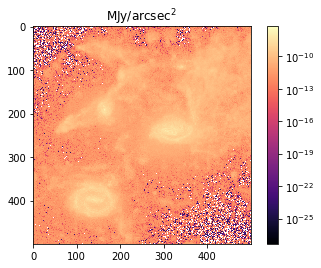

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


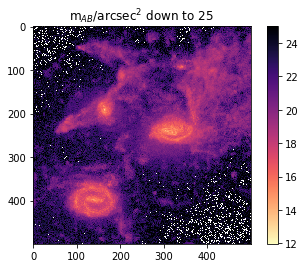

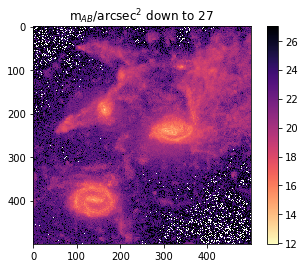

In [16]:
# First, convert to per arcsec^2 
cube_per_arc = F360M_img/4.25e10

plt.clf()
plt.imshow(cube_per_arc, norm = matplotlib.colors.LogNorm(), cmap = 'magma')
plt.title('MJy/arcsec$^2$')
plt.colorbar()
plt.show()

#{\displaystyle m_{\text{AB}}=-2.5\log _{10}f_{\nu }+8.90.}
# So now convert to AB mags (m_AB):
import math
m_AB = -2.5*np.log10(np.array(cube_per_arc)*10**6)+8.9

plt.clf()
plt.imshow(m_AB, cmap = 'magma_r', vmax=25)# norm = matplotlib.colors.LogNorm(),
plt.title('m$_{AB}$/arcsec$^2$ down to 25')
plt.colorbar()
plt.show()
plt.clf()
plt.imshow(m_AB, cmap = 'magma_r', vmax=27)# norm = matplotlib.colors.LogNorm(),
plt.title('m$_{AB}$/arcsec$^2$ down to 27')
plt.colorbar()
plt.show()



### The next step is to duplicate the PSF from the telescope
And the key is to keep the pixels of the generated PSF the same size as the 0.1" pixels of the image.
This is an useful reference: https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions#NIRCamPointSpreadFunctions-SimulatedNIRCamPSFs

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps
Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps
Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps
Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 9 steps
Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 9 steps


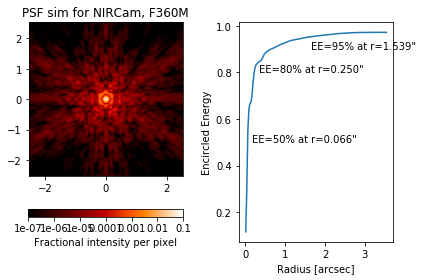

In [13]:
# First set the environmental variable
import os
os.environ['WEBBPSF_PATH'] = '/Users/beckynevin/CfA_Code/illustris_python/webbpsf-data'
import webbpsf

nircam = webbpsf.NIRCam()
nircam.pixelscale = size_pix_arc#0.0314159
nircam.filter = 'F070W'#'F210M'
psf070 = nircam.calc_psf(oversample=2)
nircam.filter = 'F115W'#'F210M'
psf115 = nircam.calc_psf(oversample=2)
nircam.filter = 'F150W'#'F210M'
psf150 = nircam.calc_psf(oversample=2)
nircam.filter = 'F300M'#'F210M'
psf300 = nircam.calc_psf(oversample=2)

nircam = webbpsf.NIRCam()
nircam.pixelscale = size_pix_arc#0.0314159
nircam.filter = 'F360M'#'F210M'
psf360 = nircam.calc_psf()


# display the PSF and plot the encircled energy
plt.subplot(1,2,1)
webbpsf.display_psf(psf360, colorbar_orientation='horizontal')
axis2 = plt.subplot(1,2,2)
webbpsf.display_ee(psf360, ax=axis2)

#psf210.writeto('nircam_F210M.fits')
plt.tight_layout()
plt.savefig('plot_nircam_f360M.pdf', overwrite=True)

### Maybe make a 1D plot of this?

0.10524250748966657 pixelscale in arcsec/pix 0.10524250748966657 pixelscale of image


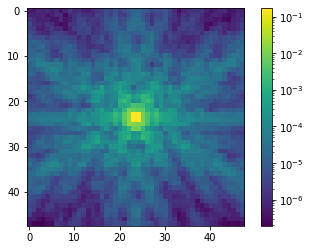

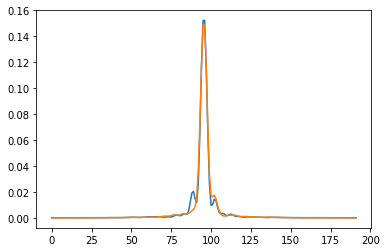

In [14]:
#print(np.shape(psf210[0].data))
#print(psf360[0].header)
print(psf360[1].header['PIXELSCL'], 'pixelscale in arcsec/pix', size_pix_arc, 'pixelscale of image')
plt.clf()
plt.imshow(psf360[1].data, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

plt.plot(np.sum(psf360[0].data,axis=0))
plt.plot(np.sum(psf360[0].data,axis=1))
plt.show()


### Try convolving

In [15]:
from scipy import signal
grad = signal.convolve2d(F360M_img, psf360[1].data, boundary='symm', mode='same')

<Figure size 432x288 with 0 Axes>

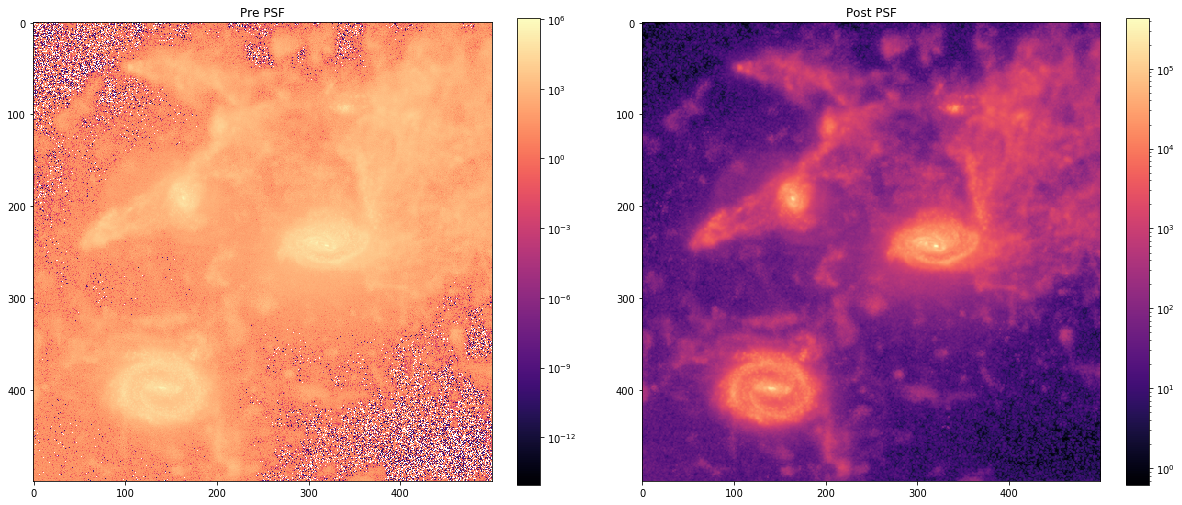

In [16]:
plt.clf()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title('Pre PSF')
im1 = ax1.imshow(F360M_img, cmap='magma', norm=matplotlib.colors.LogNorm())
plt.colorbar(im1, fraction=0.046)

ax2 = fig.add_subplot(122)

im2 = ax2.imshow(grad, cmap='magma', norm=matplotlib.colors.LogNorm())
plt.colorbar(im2, fraction=0.046)
ax2.set_title('Post PSF')
plt.show()

### Rebinning
eight for 0.6–2.3 µm observations (0.031"/pixel) and two for 2.4–5.0 µm (0.063"/pixel)
so actually the image is lower res than JWST 

factor 1.6705159918994694


<Figure size 432x288 with 0 Axes>

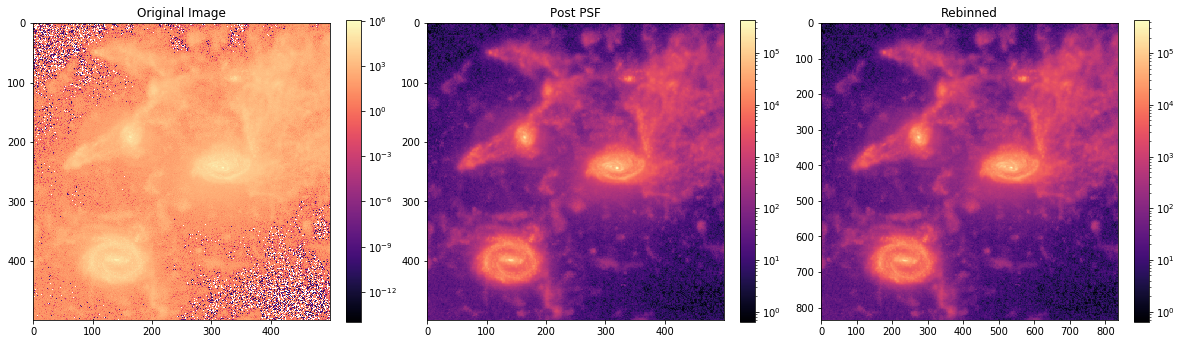

In [18]:
import scipy
factor = size_pix_arc/0.063
print('factor', factor)
rebin = scipy.ndimage.zoom(grad, factor, order=0)


plt.clf()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(131)
ax1.set_title('Original Image')
im1 = ax1.imshow(F360M_img, cmap='magma', norm=matplotlib.colors.LogNorm())
plt.colorbar(im1, fraction=0.046)

ax2 = fig.add_subplot(132)

im2 = ax2.imshow(grad, cmap='magma', norm=matplotlib.colors.LogNorm())
plt.colorbar(im2, fraction=0.046)
ax2.set_title('Post PSF')

ax3 = fig.add_subplot(133)

im3 = ax3.imshow(rebin, cmap='magma', norm=matplotlib.colors.LogNorm())
ax3.set_title('Rebinned')
plt.colorbar(im3, fraction=0.046)
plt.show()

### Noise
This is going to be a little bit trickier


### Background
The background sky can be a good source of extra photons, but apparently it really varies as a function of time of year and exposure time: https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-imaging-sensitivity

### From Snyder et al. 2019:
We convolve each image with an appropriate point- spread function (PSF) modeled with the TinyTim (Krist et al. 2011) and WebbPSF (Perrin et al. 2014) tools as ap- propriate. The resulting data product is then ready to mod- ify as appropriate for any desired effective exposure time. For our purposes, we create two sets of images with noise added, SB25 and SB27, using a procedure to ensure unifor- mity across filters and instruments. We add normally dis- tributed random sky shot noise to each pixel such that the fi- nal images achieve a 5σ limiting surface brightness of 25 and 27 magnitudes per square arcsecond, respectively.

### Here's a page for background rates in mJy/sr:
https://jwst-docs.stsci.edu/jwst-observatory-functionality/jwst-background-model

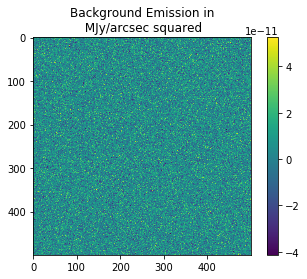

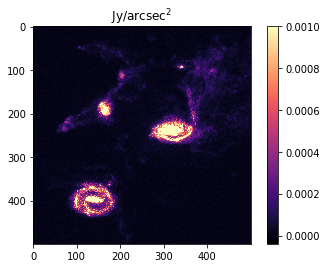

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10


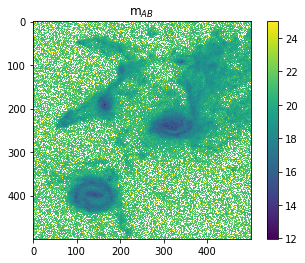

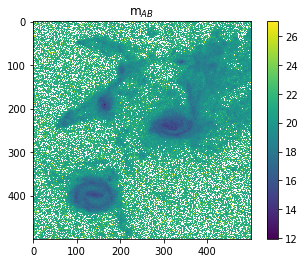

In [29]:
#@3.5 microns, the sky background is 2e-1 MJy/sr, this really seems negligible relative to what we have here
import numpy as np
import matplotlib.pyplot as plt
background = np.zeros((500,500))
mu, sigma = 2e-1, np.sqrt(2e-1) # mean and standard deviation

for i in range(np.shape(background)[0]):
    for j in range(np.shape(background)[1]):
        s = np.random.normal(mu, sigma, 1)
        background[i,j] = s

        
plt.clf()
plt.imshow(background/4.25e10)
plt.colorbar()
plt.title('Background Emission in\n MJy/arcsec squared')
plt.show()


plt.clf()
plt.imshow(10**6*(cube_per_arc+background/4.25e10), cmap = 'magma', vmax=0.001)# norm = matplotlib.colors.LogNorm(),
plt.title('Jy/arcsec$^2$')
plt.colorbar()
plt.show()

img_bg = 10**6*(cube_per_arc+background/4.25e10)

m_AB = -2.5*np.log10(img_bg)+8.9

plt.clf()
plt.imshow(m_AB, vmax=25)
plt.colorbar()
plt.title('m$_{AB}$')
plt.show()

plt.clf()
plt.imshow(m_AB, vmax=27)
plt.colorbar()
plt.title('m$_{AB}$')
plt.show()


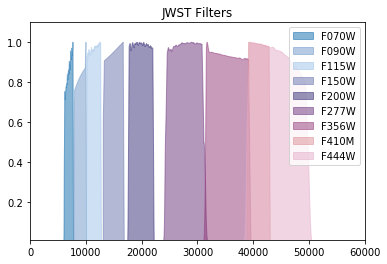

In [44]:
# So these are all Greg's filters:
# Which seem to be rougher than the official ones

F070W_g = np.loadtxt('greg_JWST_filters/nircam_f070w')
F090W_g = np.loadtxt('greg_JWST_filters/nircam_f090w')
F115W_g = np.loadtxt('greg_JWST_filters/nircam_f115w')
F150W_g = np.loadtxt('greg_JWST_filters/nircam_f150w')
F200W_g = np.loadtxt('greg_JWST_filters/nircam_f200w')
F277W_g = np.loadtxt('greg_JWST_filters/nircam_f277w')
F356W_g = np.loadtxt('greg_JWST_filters/nircam_f356w')
F444W_g = np.loadtxt('greg_JWST_filters/nircam_f444w')
F410M_g = np.loadtxt('greg_JWST_filters/nircam_F410M')


plt.clf()
plt.fill_between(F070W_g[:,0], 0, F070W_g[:,1], label='F070W', color='#0D69AB', alpha=0.5)
plt.fill_between(F090W_g[:,0], 0, F090W_g[:,1], label='F090W', color='#6E99C9', alpha=0.5)
plt.fill_between(F115W_g[:,0], 0, F115W_g[:,1], label='F115W', color='#9FC3E9', alpha=0.5)

plt.fill_between(F150W_g[:,0], 0, F150W_g[:,1], label='F150W', color='#6874AC', alpha=0.5)
plt.fill_between(F200W_g[:,0], 0, F200W_g[:,1], label='F200W', color='#342B75', alpha=0.5)

plt.fill_between(F277W_g[:,0], 0, F277W_g[:,1], label='F277W', color='#6B327B', alpha=0.5)
plt.fill_between(F356W_g[:,0], 0, F356W_g[:,1], label='F356W', color='#923978', alpha=0.5)

plt.fill_between(F410M_g[:,0], 0, F410M_g[:,1], color='#DC9095', alpha=0.5, label='F410M')

plt.fill_between(F444W_g[:,0], 0, F444W_g[:,1], label='F444W', color='#E4ADC8', alpha=0.5)


#plt.plot(F410M_g[:,0], F410M_g[:,1], label='F410M', color='#DC9095')


plt.xlim([0,60000])
plt.ylim([0.01,1.1])
plt.title(r'JWST Filters')
plt.legend()
plt.show()

In [63]:
# Try to get filter curves up and running:
#! /usr/bin/env/ python

'''plot the components of the optics file...for the TR'''

from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np

def replace_nan(items):
    for index, item in enumerate(items):
        if (item == '---'):
            items[index] = float('nan')
    return items


ofile = 'nircam_throughputs/optics/NIRCam_optics_transmission_29Oct2015.csv'

opttab = ascii.read(ofile,header_start=1,data_start=2,format='csv')


wave = opttab['Wavelength'].data.data
nvr_thru = opttab['NVR_Transmission'].data.data
nvr_wave = opttab['NVR_Wavelength'].data.data
collimator = opttab['Collimator'].data.data
sw_triplet = replace_nan(opttab['SW_Triplet'].data.data).astype('float')
sw_mirrors = replace_nan(opttab['SW_Mirrors'].data.data).astype('float')
lw_triplet = replace_nan(opttab['LW_triplet'].data.data).astype('float')
lw_mirrors = replace_nan(opttab['LW_Mirrors'].data.data).astype('float')
sw_particulates = replace_nan(opttab['SW_Particulates'].data.data).astype('float')
lw_particulates = replace_nan(opttab['LW_Particulates'].data.data).astype('float')

#remove extra entries in NVR columns
good = np.where(nvr_wave != 0.)[0]
nvr_thru = nvr_thru[good]
nvr_wave = nvr_wave[good]


#interpolate NVR to the same wavelength scale as the other columns
nvr_interp = np.interp(wave,nvr_wave,nvr_thru)

#combine the elements to produce a SW optics curve and a LW optics curve
#The 0.98 factor is a 'contingency factor' John Stansberry included in a 
#previous version. He said we can keep it out for this version
sw_optics = collimator * sw_triplet * sw_mirrors * sw_particulates #* 0.98
lw_optics = collimator * lw_triplet * lw_mirrors * lw_particulates #* 0.98


f,a = plt.subplots()
a.plot(wave,collimator,color='red',label='Collimator')

a.plot(wave,sw_triplet,color='blue',label='SW Triplet')
a.plot(wave,sw_mirrors,color='black',label='SW Mirrors')
a.plot(wave,sw_particulates,color='green',label='SW Particulates')

a.plot(wave,lw_triplet,color='blue',linestyle='--',label='LW Triplet')
a.plot(wave,lw_mirrors,color='black',linestyle='--',label='LW Mirrors')
a.plot(wave,lw_particulates,color='green',linestyle='--',label='LW Particulates')

a.plot(nvr_wave,nvr_thru,color='orange',label='NVR')

a.plot(wave,sw_optics,color='magenta',label='Total SW')
a.plot(wave,lw_optics,color='magenta',linestyle='--',label='Total LW')

a.set_xlim(0.5,5.5)
a.set_ylabel('Throughput')
a.set_xlabel('Wavelength (microns)')
a.legend(loc='lower right')

f.savefig('Optics_components_plot.pdf')
plt.close(f)
